# Pareto Frontier: Aggregated Eval vs Jailbreak Harm

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import sys
import torch

sys.path.append('..')
from capped.plots import (
    parse_experiment_id, format_layer_range, format_cap_label,
    CONFIG_COLORS, CONFIG_DISPLAY_NAMES
)

plt.style.use('./arena.mplstyle')

In [2]:
# ============================================================================
# Configuration
# ============================================================================

model = "qwen-3-32b"
total_layers = 64
base_dir = f"/workspace/{model}"

# Configs to analyze
config_names = ["role_trait", "baseline"]

# ============================================================================
# Load Experiment IDs from Config Files (for labeling)
# ============================================================================
# These IDs determine which pareto-optimal points get labels
# Points NOT in this list will still be plotted but won't be labeled
# Set to None to label ALL pareto-optimal points

label_experiment_ids = set()
for config_name in config_names:
    if config_name == "baseline":
        continue
    config_path = f"{base_dir}/capped/configs/contrast/{config_name}_sliding_config.pt"
    if os.path.exists(config_path):
        cfg = torch.load(config_path, weights_only=False)
        ids = [exp['id'] for exp in cfg['experiments']]
        label_experiment_ids.update(ids)
        print(f"Loaded {len(ids)} experiment IDs from {config_name}")
    else:
        print(f"Warning: Config file not found for {config_name}: {config_path}")

if label_experiment_ids:
    label_experiment_ids = list(label_experiment_ids)
    print(f"\nTotal unique experiment IDs for labeling: {len(label_experiment_ids)}")
else:
    label_experiment_ids = None
    print("No config files found - will label all pareto-optimal points")

# ============================================================================
# Label Exclude List
# ============================================================================
# Add experiment_ids here to NOT label them on the pareto frontier
# (even if they're in label_experiment_ids)
EXCLUDE_LABELS = [
    "layers_64:72-p0.01",
    "layers_64:80-p0.01",
    "layers_52:76-p0.01",
    "layers_32:48-p0.5"]

# ============================================================================
# Eval Metrics
# ============================================================================
EVAL_METRICS = {
    'ifeval': {
        'metric': 'inst_level_strict_acc,none',
        'display_name': 'IFEval',
        'higher_is_better': True
    },
    'mmlu_pro': {
        'metric': 'exact_match,custom-extract',
        'display_name': 'MMLU Pro',
        'higher_is_better': True
    },
    'eq_bench': {
        'metric': 'eqbench,none',
        'display_name': 'EQ-Bench',
        'higher_is_better': True
    },
    'gsm8k': {
        'metric': 'exact_match,flexible-extract',
        'display_name': 'GSM8K',
        'higher_is_better': True
    }
}

print(f"Model: {model}")

Loaded 124 experiment IDs from role_trait

Total unique experiment IDs for labeling: 124
Model: qwen-3-32b


In [3]:
def load_experiment_data(tasks, config_names, base_dir):
    """Load experiment data for specified tasks and configs."""
    all_rows = []
    bench_dir = f"{base_dir}/capped/benchmarks"

    for task in tasks:
        task_dir = f"{bench_dir}/{task}"
        if not os.path.exists(task_dir):
            print(f"Warning: Task directory not found: {task_dir}")
            continue

        for config_name in config_names:
            config_dir = f"{task_dir}/{config_name}"
            if not os.path.exists(config_dir):
                continue

            if config_name == "baseline":
                run_dirs = [d for d in os.listdir(config_dir) if d.startswith("2025-")]
                for run_dir in sorted(run_dirs):
                    results_path = os.path.join(config_dir, run_dir, "results.json")
                    manifest_path = os.path.join(config_dir, run_dir, "manifest.json")
                    if os.path.exists(results_path):
                        with open(results_path, "r") as f:
                            data = json.load(f)
                        vllm = False
                        if os.path.exists(manifest_path):
                            with open(manifest_path, "r") as f:
                                manifest = json.load(f)
                                vllm = manifest.get("vllm", False)
                        if "results" in data and task in data["results"]:
                            row = {
                                "task_name": task,
                                "config_name": config_name,
                                "experiment_id": "baseline",
                                "run_dir": run_dir,
                                "vllm": vllm
                            }
                            row.update(data["results"][task])
                            row.pop("alias", None)
                            all_rows.append(row)
            else:
                for experiment_id in os.listdir(config_dir):
                    exp_dir = os.path.join(config_dir, experiment_id)
                    if not os.path.isdir(exp_dir):
                        continue
                    run_dirs = [d for d in os.listdir(exp_dir) if d.startswith("2025-")]
                    for run_dir in sorted(run_dirs):
                        results_path = os.path.join(exp_dir, run_dir, "results.json")
                        manifest_path = os.path.join(exp_dir, run_dir, "manifest.json")
                        if os.path.exists(results_path):
                            with open(results_path, "r") as f:
                                data = json.load(f)
                            vllm = False
                            if os.path.exists(manifest_path):
                                with open(manifest_path, "r") as f:
                                    manifest = json.load(f)
                                    vllm = manifest.get("vllm", False)
                            if "results" in data and task in data["results"]:
                                row = {
                                    "task_name": task,
                                    "config_name": config_name,
                                    "experiment_id": experiment_id,
                                    "run_dir": run_dir,
                                    "vllm": vllm
                                }
                                row.update(data["results"][task])
                                row.pop("alias", None)
                                all_rows.append(row)

    return pd.DataFrame(all_rows)


def load_jailbreak_scores(config_name, base_dir):
    """Load jailbreak scores and calculate combined harm rate."""
    scores_path = f"{base_dir}/capped/results/{config_name}_jailbreak_1100_scores.jsonl"
    if not os.path.exists(scores_path):
        return pd.DataFrame()
    
    with open(scores_path, "r") as f:
        scores = [json.loads(line) for line in f]
    df = pd.DataFrame(scores)

    # Also load sliding scores if they exist
    sliding_path = f"{base_dir}/capped/results/{config_name}_sliding_jailbreak_1100_scores.jsonl"
    if os.path.exists(sliding_path):
        with open(sliding_path, "r") as f:
            sliding_scores = [json.loads(line) for line in f]
        df = pd.DataFrame(scores + sliding_scores)

    harm_labels = ["enough_info", "enough_info_and_follow_perfectly"]
    results = []
    for exp_id, group in df.groupby("experiment_id"):
        n_total = len(group)
        n_harmful = len(group[group["score"].isin(harm_labels)])
        harm_rate = (n_harmful / n_total * 100) if n_total > 0 else 0.0
        results.append({
            "experiment_id": exp_id,
            "config_name": config_name,
            "harm_rate": harm_rate,
            "n_harmful": n_harmful,
            "n_total": n_total
        })
    return pd.DataFrame(results)


def load_baseline_jailbreak(base_dir, baseline_type="prompted"):
    """Load baseline (unsteered) jailbreak scores."""
    if baseline_type == "prompted":
        scores_path = f"{base_dir}/evals/unsteered/unsteered_scores.jsonl"
    else:
        scores_path = f"{base_dir}/evals/unsteered/unsteered_default_scores.jsonl"
    
    if not os.path.exists(scores_path):
        return None
    
    with open(scores_path, "r") as f:
        scores = [json.loads(line) for line in f]
    df = pd.DataFrame(scores)
    
    harm_labels = ["enough_info", "enough_info_and_follow_perfectly"]
    n_total = len(df)
    n_harmful = len(df[df["score"].isin(harm_labels)])
    return (n_harmful / n_total * 100) if n_total > 0 else 0.0


print("Data loading functions defined")

Data loading functions defined


In [4]:
def calculate_pareto_frontier(df, x_col='eval_pct_change', y_col='harm_pct_change'):
    """
    Identify Pareto-optimal points.
    
    For our case:
    - X-axis (eval_pct_change): Higher is better (less performance degradation)
    - Y-axis (harm_pct_change): Lower is better (more harm reduction)
    """
    df = df.copy()
    df['is_pareto'] = False
    points = df[[x_col, y_col]].values
    
    for i in range(len(points)):
        is_dominated = False
        for j in range(len(points)):
            if i == j:
                continue
            # j dominates i if: j.x >= i.x AND j.y <= i.y (with at least one strict)
            x_better_or_equal = points[j][0] >= points[i][0]
            y_better_or_equal = points[j][1] <= points[i][1]
            strictly_better = (points[j][0] > points[i][0]) or (points[j][1] < points[i][1])
            if x_better_or_equal and y_better_or_equal and strictly_better:
                is_dominated = True
                break
        if not is_dominated:
            df.loc[df.index[i], 'is_pareto'] = True
    return df


def prepare_pareto_data(df_eval, df_jailbreak_dict, eval_name, baseline_eval_value, baseline_harm_rate):
    """Prepare data for Pareto analysis by combining eval and jailbreak metrics."""
    eval_config = EVAL_METRICS[eval_name]
    metric_col = eval_config['metric']
    all_data = []

    for config_name, df_jailbreak in df_jailbreak_dict.items():
        if config_name == 'baseline':
            continue
        config_eval = df_eval[df_eval['config_name'] == config_name]
        if len(config_eval) == 0:
            continue

        grouped = config_eval.groupby(['config_name', 'experiment_id']).agg({
            metric_col: 'max'
        }).reset_index()

        merged = grouped.merge(
            df_jailbreak[['experiment_id', 'harm_rate']],
            on='experiment_id',
            how='inner'
        )
        if len(merged) == 0:
            continue

        merged['eval_value'] = merged[metric_col]
        merged['eval_pct_change'] = ((merged['eval_value'] - baseline_eval_value) / baseline_eval_value * 100)
        merged['harm_pct_change'] = ((merged['harm_rate'] - baseline_harm_rate) / baseline_harm_rate * 100)

        parsed = merged['experiment_id'].apply(parse_experiment_id)
        merged['layer_spec'] = parsed.apply(lambda x: x[0])
        merged['cap_value'] = parsed.apply(lambda x: x[2])
        merged['layer_label'] = merged['layer_spec'].apply(format_layer_range)
        merged['cap_label'] = merged['cap_value'].apply(format_cap_label)
        merged['display_name'] = merged.apply(
            lambda row: f"{row['layer_label']}, {row['cap_label']}",
            axis=1
        )
        all_data.append(merged)

    if len(all_data) == 0:
        return pd.DataFrame()
    
    df_combined = pd.concat(all_data, ignore_index=True)
    df_combined = calculate_pareto_frontier(df_combined)
    return df_combined


print("Pareto calculation functions defined")

Pareto calculation functions defined


In [5]:
# Load baseline harm rate
baseline_harm = load_baseline_jailbreak(base_dir, baseline_type="prompted")
print(f"Baseline jailbreak harm rate: {baseline_harm:.2f}%")

# Load jailbreak data for each config
jailbreak_data = {}
for config_name in config_names:
    if config_name == 'baseline':
        continue
    df_jb = load_jailbreak_scores(config_name, base_dir)
    if len(df_jb) > 0:
        jailbreak_data[config_name] = df_jb
        print(f"Loaded {len(df_jb)} experiments for {config_name}")

print(f"\nLoaded jailbreak data for {len(jailbreak_data)} configs")

Baseline jailbreak harm rate: 83.25%
Loaded 148 experiments for role_trait

Loaded jailbreak data for 1 configs


In [6]:
exp_id = "layers_46:54-p0.25"

In [7]:
jailbreak_data['role_trait'][jailbreak_data['role_trait']['experiment_id'] == exp_id]


,experiment_id,config_name,harm_rate,n_harmful,n_total
105,layers_46:54-p0.25,role_trait,41.090909,452,1100


## IFEval

In [8]:
# Load IFEval data
df_ifeval = load_experiment_data(['ifeval'], config_names, base_dir)

print(f"Loaded {len(df_ifeval)} IFEval experiment runs")
print(f"\nConfig breakdown:")
for config in df_ifeval['config_name'].unique():
    print(f"  {config}: {len(df_ifeval[df_ifeval['config_name'] == config])} runs")

Loaded 443 IFEval experiment runs

Config breakdown:
  role_trait: 440 runs
  baseline: 3 runs


In [9]:
# Show baseline runs for IFEval
df_ifeval[df_ifeval['config_name'] == 'baseline'].head()

,task_name,config_name,experiment_id,run_dir,vllm,"prompt_level_strict_acc,none","prompt_level_strict_acc_stderr,none","inst_level_strict_acc,none","inst_level_strict_acc_stderr,none","prompt_level_loose_acc,none","prompt_level_loose_acc_stderr,none","inst_level_loose_acc,none","inst_level_loose_acc_stderr,none"
440,ifeval,baseline,baseline,2025-10-16_23-43-40,False,0.468000,0.022337,0.601552,N/A,0.486000,0.022374,0.615783,N/A
441,ifeval,baseline,baseline,2025-10-21_13-16-35,True,0.656192,0.020440,0.757794,N/A,0.663586,0.020332,0.767386,N/A
442,ifeval,baseline,baseline,2025-10-22_08-03-50,True,0.643253,0.020615,0.748201,N/A,0.658041,0.020413,0.762590,N/A


In [10]:
df_ifeval[df_ifeval['experiment_id'] == exp_id]

,task_name,config_name,experiment_id,run_dir,vllm,"prompt_level_strict_acc,none","prompt_level_strict_acc_stderr,none","inst_level_strict_acc,none","inst_level_strict_acc_stderr,none","prompt_level_loose_acc,none","prompt_level_loose_acc_stderr,none","inst_level_loose_acc,none","inst_level_loose_acc_stderr,none"
88,ifeval,role_trait,layers_46:54-p0.25,2025-10-21_22-10-17,True,0.613678,0.020953,0.724221,N/A,0.635860,0.020707,0.742206,N/A
89,ifeval,role_trait,layers_46:54-p0.25,2025-10-21_23-14-58,True,0.641405,0.020638,0.750600,N/A,0.659889,0.020387,0.766187,N/A
90,ifeval,role_trait,layers_46:54-p0.25,2025-10-22_22-12-18,False,0.630314,0.020773,0.741007,N/A,0.652495,0.020491,0.761391,N/A


In [32]:
# Filter IFEval data to vllm for baseline and not vllm for other configs
df_ifeval_filtered = df_ifeval[((df_ifeval['config_name'] == 'baseline') & df_ifeval['vllm']) | ((df_ifeval['config_name'] != 'baseline') & ~df_ifeval['vllm'])] 

print(f"After filtering: {len(df_ifeval_filtered)} runs")
for config in df_ifeval['config_name'].unique():
    print(f"  {config}: {len(df_ifeval_filtered[df_ifeval_filtered['config_name'] == config])} runs")

# Get baseline value
metric_col = EVAL_METRICS['ifeval']['metric']
baseline_ifeval = df_ifeval_filtered[df_ifeval_filtered['config_name'] == 'baseline']
if len(baseline_ifeval) > 0:
    baseline_ifeval_value = baseline_ifeval[metric_col].iloc[0]
    print(f"\nBaseline IFEval value: {baseline_ifeval_value:.4f}")
else:
    baseline_ifeval_value = None
    print("Warning: No baseline found!")

After filtering: 158 runs
  role_trait: 156 runs
  baseline: 2 runs

Baseline IFEval value: 0.7578


In [30]:
# Prepare Pareto data for IFEval
if baseline_ifeval_value is not None:
    df_ifeval_pareto = prepare_pareto_data(
        df_ifeval_filtered, jailbreak_data, 'ifeval',
        baseline_ifeval_value, baseline_harm
    )
    print(f"IFEval pareto data: {len(df_ifeval_pareto)} experiments")
    print(f"Pareto-optimal: {df_ifeval_pareto['is_pareto'].sum()}")
else:
    df_ifeval_pareto = pd.DataFrame()

IFEval pareto data: 148 experiments
Pareto-optimal: 7


## MMLU Pro

In [13]:
# Load MMLU Pro data
df_mmlu = load_experiment_data(['mmlu_pro'], config_names, base_dir)

print(f"Loaded {len(df_mmlu)} MMLU Pro experiment runs")
print(f"\nConfig breakdown:")
for config in df_mmlu['config_name'].unique():
    print(f"  {config}: {len(df_mmlu[df_mmlu['config_name'] == config])} runs")

Loaded 363 MMLU Pro experiment runs

Config breakdown:
  role_trait: 356 runs
  baseline: 7 runs


In [14]:
# Show baseline runs for MMLU Pro
df_mmlu[df_mmlu['config_name'] == 'baseline'].head()

,task_name,config_name,experiment_id,run_dir,vllm,"exact_match,custom-extract","exact_match_stderr,custom-extract"
356,mmlu_pro,baseline,baseline,2025-10-17_00-24-48,False,0.640000,0.012570
357,mmlu_pro,baseline,baseline,2025-10-17_00-25-51,False,0.675000,0.012285
358,mmlu_pro,baseline,baseline,2025-10-17_00-26-30,False,0.702143,0.011878
359,mmlu_pro,baseline,baseline,2025-10-17_00-27-22,False,0.714286,0.011793
360,mmlu_pro,baseline,baseline,2025-10-18_07-36-23,True,0.674286,0.012285


In [15]:
df_mmlu[df_mmlu['experiment_id'] == exp_id]

,task_name,config_name,experiment_id,run_dir,vllm,"exact_match,custom-extract","exact_match_stderr,custom-extract"
158,mmlu_pro,role_trait,layers_46:54-p0.25,2025-10-21_22-28-05,True,0.677857,0.012232
159,mmlu_pro,role_trait,layers_46:54-p0.25,2025-10-22_22-02-50,False,0.672143,0.012316


In [16]:
# Filter MMLU Pro data
df_mmlu_filtered = df_mmlu[~df_mmlu['vllm']]

print(f"After filtering: {len(df_mmlu_filtered)} runs")
for config in df_mmlu['config_name'].unique():
    print(f"  {config}: {len(df_mmlu_filtered[df_mmlu_filtered['config_name'] == config])} runs")

# Get baseline value
metric_col = EVAL_METRICS['mmlu_pro']['metric']
baseline_mmlu = df_mmlu_filtered[df_mmlu_filtered['config_name'] == 'baseline']
if len(baseline_mmlu) > 0:
    baseline_mmlu_value = baseline_mmlu[metric_col].iloc[0]
    print(f"\nBaseline MMLU Pro value: {baseline_mmlu_value:.4f}")
else:
    baseline_mmlu_value = None
    print("Warning: No baseline found!")

After filtering: 176 runs
  role_trait: 172 runs
  baseline: 4 runs

Baseline MMLU Pro value: 0.6400


In [17]:
# Prepare Pareto data for MMLU Pro
if baseline_mmlu_value is not None:
    df_mmlu_pareto = prepare_pareto_data(
        df_mmlu_filtered, jailbreak_data, 'mmlu_pro',
        baseline_mmlu_value, baseline_harm
    )
    print(f"MMLU Pro pareto data: {len(df_mmlu_pareto)} experiments")
    print(f"Pareto-optimal: {df_mmlu_pareto['is_pareto'].sum()}")
else:
    df_mmlu_pareto = pd.DataFrame()

MMLU Pro pareto data: 147 experiments
Pareto-optimal: 13


## EQ-Bench

In [18]:
# Load EQ-Bench data
df_eq = load_experiment_data(['eq_bench'], config_names, base_dir)

print(f"Loaded {len(df_eq)} EQ-Bench experiment runs")
print(f"\nConfig breakdown:")
for config in df_eq['config_name'].unique():
    print(f"  {config}: {len(df_eq[df_eq['config_name'] == config])} runs")

Loaded 447 EQ-Bench experiment runs

Config breakdown:
  role_trait: 444 runs
  baseline: 3 runs


In [19]:
# Show baseline runs for EQ-Bench
df_eq[df_eq['config_name'] == 'baseline'].head()

,task_name,config_name,experiment_id,run_dir,vllm,"eqbench,none","eqbench_stderr,none","percent_parseable,none","percent_parseable_stderr,none"
444,eq_bench,baseline,baseline,2025-10-17_07-13-57,False,82.294152,1.313243,100.0,0.0
445,eq_bench,baseline,baseline,2025-10-21_13-16-35,True,82.249032,1.313882,100.0,0.0
446,eq_bench,baseline,baseline,2025-10-22_08-33-01,True,82.281191,1.310574,100.0,0.0


In [20]:
df_eq[df_eq['experiment_id'] == exp_id].head()

,task_name,config_name,experiment_id,run_dir,vllm,"eqbench,none","eqbench_stderr,none","percent_parseable,none","percent_parseable_stderr,none"
288,eq_bench,role_trait,layers_46:54-p0.25,2025-10-21_22-00-26,True,79.530642,1.482432,100.0,0.0
289,eq_bench,role_trait,layers_46:54-p0.25,2025-10-21_23-38-25,True,80.262974,1.353601,100.0,0.0
290,eq_bench,role_trait,layers_46:54-p0.25,2025-10-22_09-59-20,False,82.583134,1.222633,100.0,0.0


In [21]:
# Filter EQ-Bench data
df_eq_filtered = df_eq[~df_eq['vllm']]

print(f"After filtering: {len(df_eq_filtered)} runs")
for config in df_eq['config_name'].unique():
    print(f"  {config}: {len(df_eq_filtered[df_eq_filtered['config_name'] == config])} runs")

# Get baseline value
metric_col = EVAL_METRICS['eq_bench']['metric']
baseline_eq = df_eq_filtered[df_eq_filtered['config_name'] == 'baseline']
if len(baseline_eq) > 0:
    baseline_eq_value = baseline_eq[metric_col].iloc[0]
    print(f"\nBaseline EQ-Bench value: {baseline_eq_value:.4f}")
else:
    baseline_eq_value = None
    print("Warning: No baseline found!")

After filtering: 161 runs
  role_trait: 160 runs
  baseline: 1 runs

Baseline EQ-Bench value: 82.2942


In [22]:
# Prepare Pareto data for EQ-Bench
if baseline_eq_value is not None:
    df_eq_pareto = prepare_pareto_data(
        df_eq_filtered, jailbreak_data, 'eq_bench',
        baseline_eq_value, baseline_harm
    )
    print(f"EQ-Bench pareto data: {len(df_eq_pareto)} experiments")
    print(f"Pareto-optimal: {df_eq_pareto['is_pareto'].sum()}")
else:
    df_eq_pareto = pd.DataFrame()

EQ-Bench pareto data: 148 experiments
Pareto-optimal: 14


## GSM8K

In [23]:
# Load GSM8K data
df_gsm8k = load_experiment_data(['gsm8k'], config_names, base_dir)

print(f"Loaded {len(df_gsm8k)} GSM8K experiment runs")
print(f"\nConfig breakdown:")
for config in df_gsm8k['config_name'].unique():
    print(f"  {config}: {len(df_gsm8k[df_gsm8k['config_name'] == config])} runs")

Loaded 483 GSM8K experiment runs

Config breakdown:
  role_trait: 479 runs
  baseline: 4 runs


In [24]:
# Show baseline runs for GSM8K
df_gsm8k[df_gsm8k['config_name'] == 'baseline'].head()

,task_name,config_name,experiment_id,run_dir,vllm,"exact_match,strict-match","exact_match_stderr,strict-match","exact_match,flexible-extract","exact_match_stderr,flexible-extract"
479,gsm8k,baseline,baseline,2025-10-20_01-30-55,True,0.0,0.0,0.808,0.012462
480,gsm8k,baseline,baseline,2025-10-20_04-22-24,False,0.0,0.0,0.806,0.012511
481,gsm8k,baseline,baseline,2025-10-21_13-16-35,True,0.0,0.0,0.804,0.012560
482,gsm8k,baseline,baseline,2025-10-22_08-33-53,True,0.0,0.0,0.804,0.012560


In [25]:
df_gsm8k[df_gsm8k['experiment_id'] == exp_id].head()

,task_name,config_name,experiment_id,run_dir,vllm,"exact_match,strict-match","exact_match_stderr,strict-match","exact_match,flexible-extract","exact_match_stderr,flexible-extract"
90,gsm8k,role_trait,layers_46:54-p0.25,2025-10-21_22-22-38,True,0.0,0.0,0.833,0.011800
91,gsm8k,role_trait,layers_46:54-p0.25,2025-10-21_23-47-28,True,0.0,0.0,0.816,0.012259
92,gsm8k,role_trait,layers_46:54-p0.25,2025-10-22_14-55-09,False,0.0,0.0,0.583,0.015600


In [26]:
# Filter GSM8K data
df_gsm8k_filtered = df_gsm8k[df_gsm8k['vllm']]

print(f"After filtering: {len(df_gsm8k_filtered)} runs")
for config in df_gsm8k['config_name'].unique():
    print(f"  {config}: {len(df_gsm8k_filtered[df_gsm8k_filtered['config_name'] == config])} runs")

# Get baseline value
metric_col = EVAL_METRICS['gsm8k']['metric']
baseline_gsm8k = df_gsm8k_filtered[df_gsm8k_filtered['config_name'] == 'baseline']
if len(baseline_gsm8k) > 0:
    baseline_gsm8k_value = baseline_gsm8k[metric_col].iloc[0]
    print(f"\nBaseline GSM8K value: {baseline_gsm8k_value:.4f}")
else:
    baseline_gsm8k_value = None
    print("Warning: No baseline found!")

After filtering: 322 runs
  role_trait: 319 runs
  baseline: 3 runs

Baseline GSM8K value: 0.8080


In [27]:
# Prepare Pareto data for GSM8K
if baseline_gsm8k_value is not None:
    df_gsm8k_pareto = prepare_pareto_data(
        df_gsm8k_filtered, jailbreak_data, 'gsm8k',
        baseline_gsm8k_value, baseline_harm
    )
    print(f"GSM8K pareto data: {len(df_gsm8k_pareto)} experiments")
    print(f"Pareto-optimal: {df_gsm8k_pareto['is_pareto'].sum()}")
else:
    df_gsm8k_pareto = pd.DataFrame()

GSM8K pareto data: 148 experiments
Pareto-optimal: 7


In [33]:
# Merge all 4 eval pareto dataframes
dfs_to_merge = [
    ('ifeval', df_ifeval_pareto),
    ('mmlu_pro', df_mmlu_pareto),
    ('eq_bench', df_eq_pareto),
    ('gsm8k', df_gsm8k_pareto)
]

# Start with the first dataframe
df_agg = dfs_to_merge[0][1][['experiment_id', 'config_name', 'eval_pct_change', 'harm_pct_change', 'display_name']].copy()
df_agg = df_agg.rename(columns={'eval_pct_change': f'{dfs_to_merge[0][0]}_pct_change'})

# Merge the rest
for eval_name, df_eval in dfs_to_merge[1:]:
    df_temp = df_eval[['experiment_id', 'config_name', 'eval_pct_change']].copy()
    df_temp = df_temp.rename(columns={'eval_pct_change': f'{eval_name}_pct_change'})
    df_agg = df_agg.merge(df_temp, on=['experiment_id', 'config_name'], how='inner')

print(f"Merged data: {len(df_agg)} experiments with all 4 evals")

# Calculate sum of all eval percentage changes
eval_cols = [f'{name}_pct_change' for name in EVAL_METRICS.keys()]
df_agg['sum_pct_change'] = df_agg[eval_cols].sum(axis=1)

print(f"Sum change range: [{df_agg['sum_pct_change'].min():.2f}, {df_agg['sum_pct_change'].max():.2f}]")
print(f"Harm change range: [{df_agg['harm_pct_change'].min():.2f}%, {df_agg['harm_pct_change'].max():.2f}%]")

# Calculate Pareto frontier
df_agg_pareto = calculate_pareto_frontier(df_agg, x_col='sum_pct_change', y_col='harm_pct_change')
print(f"\nPareto-optimal points: {df_agg_pareto['is_pareto'].sum()}")

Merged data: 147 experiments with all 4 evals
Sum change range: [-25.97, 8.97]
Harm change range: [-91.15%, -3.58%]

Pareto-optimal points: 14


After filtering large spans: 143 experiments
Pareto-optimal: 13
Unique n_layers: [np.int64(4), np.int64(8), np.int64(16)]
Unique cap_pct: [np.float64(0.01), np.float64(0.25), np.float64(0.5), np.float64(0.75)]


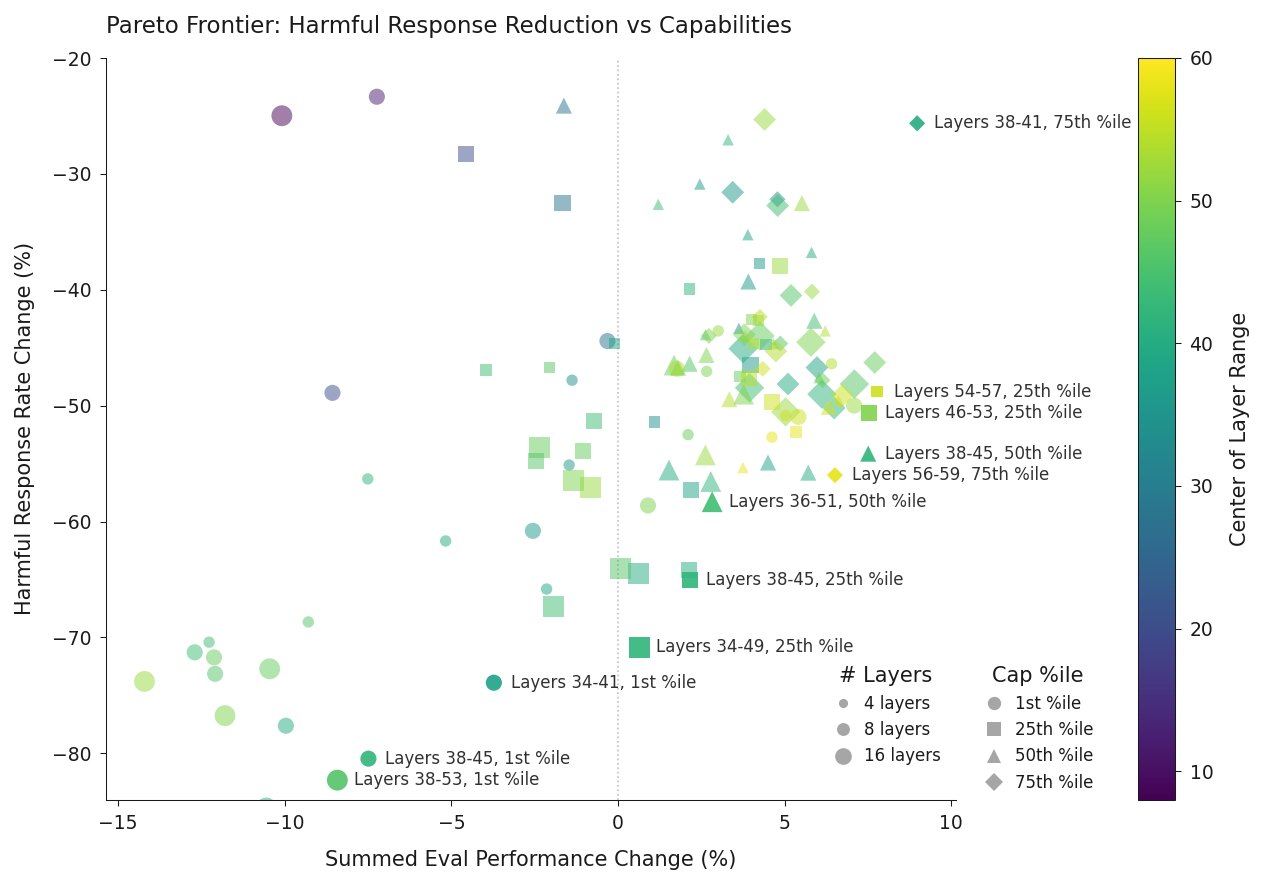

In [41]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(9, 6))

# Parse experiment parameters for visualization
def parse_exp_params(exp_id):
    """Extract layer_start, layer_end, n_layers, layer_center, cap_pct from experiment_id"""
    layer_spec, _, cap_value = parse_experiment_id(exp_id)
    if layer_spec is None:
        return None, None, None, None, None
    parts = layer_spec.split(':')
    layer_start, layer_end = int(parts[0]), int(parts[1])
    n_layers = layer_end - layer_start
    layer_center = (layer_start + layer_end) / 2
    # Extract cap percentile (e.g., 'p0.01' -> 0.01)
    cap_pct = float(cap_value[1:]) if cap_value else None
    return layer_start, layer_end, n_layers, layer_center, cap_pct

# Add parsed columns to dataframe
df_plot = df_agg_pareto.copy()
parsed = df_plot['experiment_id'].apply(parse_exp_params)
df_plot['layer_start'] = parsed.apply(lambda x: x[0])
df_plot['layer_end'] = parsed.apply(lambda x: x[1])
df_plot['n_layers'] = parsed.apply(lambda x: x[2])
df_plot['layer_center'] = parsed.apply(lambda x: x[3])
df_plot['cap_pct'] = parsed.apply(lambda x: x[4])

# Filter out large layer spans (40, 80)
df_plot = df_plot[df_plot['n_layers'] <= 24]

# Recalculate pareto frontier after filtering
df_plot = calculate_pareto_frontier(df_plot, x_col='sum_pct_change', y_col='harm_pct_change')

print(f"After filtering large spans: {len(df_plot)} experiments")
print(f"Pareto-optimal: {df_plot['is_pareto'].sum()}")
print(f"Unique n_layers: {sorted(df_plot['n_layers'].unique())}")
print(f"Unique cap_pct: {sorted(df_plot['cap_pct'].unique())}")

# Visualization mappings
# 1. Layer center -> color (continuous gradient)
cmap = plt.cm.viridis
layer_center_min = df_plot['layer_center'].min()
layer_center_max = df_plot['layer_center'].max()
norm = Normalize(vmin=layer_center_min, vmax=layer_center_max)

# 2. # of layers -> marker size
size_map = {8: 30, 16: 60, 24: 100}
size_map = {4: 30, 8: 60, 16: 100}

# 3. % cap -> marker shape
shape_map = {0.01: 'o', 0.25: 's', 0.5: '^', 0.75: 'D'}
shape_labels = {0.01: '1st %ile', 0.25: '25th %ile', 0.5: '50th %ile', 0.75: '75th %ile'}

# Plot non-pareto points (lower alpha)
for _, row in df_plot[~df_plot['is_pareto']].iterrows():
    color = cmap(norm(row['layer_center']))
    size = size_map.get(row['n_layers'], 40)
    marker = shape_map.get(row['cap_pct'], 'o')
    ax.scatter(
        row['sum_pct_change'],
        row['harm_pct_change'],
        c=[color],
        s=size,
        marker=marker,
        alpha=0.5,
        edgecolors='none'
    )

# Plot pareto points (higher alpha)
for _, row in df_plot[df_plot['is_pareto']].iterrows():
    color = cmap(norm(row['layer_center']))
    size = size_map.get(row['n_layers'], 40)
    marker = shape_map.get(row['cap_pct'], 'o')
    ax.scatter(
        row['sum_pct_change'],
        row['harm_pct_change'],
        c=[color],
        s=size,
        marker=marker,
        alpha=0.9,
        edgecolors='none'
    )

# Add colorbar for layer center (moved further right with pad)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Center of Layer Range', pad=0.15)

# Create legend handles for size (# of layers)
size_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=np.sqrt(size_map[4]), label='4 layers', alpha=0.7),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=np.sqrt(size_map[8]), label='8 layers', alpha=0.7),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=np.sqrt(size_map[16]), label='16 layers', alpha=0.7),
    # Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
    #        markersize=np.sqrt(size_map[24]), label='24 layers', alpha=0.7),
]

# Create legend handles for shape (% cap)
shape_handles = [
    Line2D([0], [0], marker=shape_map[0.01], color='w', markerfacecolor='gray', 
           markersize=8, label='1st %ile', alpha=0.7),
    Line2D([0], [0], marker=shape_map[0.25], color='w', markerfacecolor='gray', 
           markersize=8, label='25th %ile', alpha=0.7),
    Line2D([0], [0], marker=shape_map[0.5], color='w', markerfacecolor='gray', 
           markersize=8, label='50th %ile', alpha=0.7),
    Line2D([0], [0], marker=shape_map[0.75], color='w', markerfacecolor='gray', 
           markersize=8, label='75th %ile', alpha=0.7),
]

# Add two legends side by side at bottom right
legend1 = ax.legend(handles=size_handles, title='# Layers', loc='upper right', 
                    bbox_to_anchor=(1.0, 0.2), fontsize=8)
ax.add_artist(legend1)
legend2 = ax.legend(handles=shape_handles, title='Cap %ile', loc='upper right',
                    bbox_to_anchor=(1.18, 0.2), fontsize=8)

# Add labels for Pareto-optimal points
pareto_points = df_plot[df_plot['is_pareto']].sort_values('sum_pct_change')
for _, row in pareto_points.iterrows():
    exp_id = row['experiment_id']
    
    # Skip if in exclude list
    if exp_id in EXCLUDE_LABELS:
        continue
    
    # Skip if label_experiment_ids is set and this ID is not in it
    if label_experiment_ids is not None and exp_id not in label_experiment_ids:
        continue
    
    layer_spec, _, cap_value = parse_experiment_id(exp_id)
    layer_label = format_layer_range(layer_spec)
    cap_label = format_cap_label(cap_value)
    label_text = f"{layer_label}, {cap_label} %ile"
    
    ax.annotate(
        label_text,
        xy=(row['sum_pct_change'], row['harm_pct_change']),
        xytext=(8, 0),
        textcoords='offset points',
        fontsize=8,
        alpha=0.9,
        va='center'
    )

# Reference lines at origin
ax.axhline(y=0, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Labels and title
ax.set_xlabel('Summed Eval Performance Change (%)')
ax.set_ylabel('Harmful Response Rate Change (%)')
ax.set_title('Pareto Frontier: Harmful Response Reduction vs Capabilities')

ax.set_ylim(-84, -20)




plt.tight_layout()
plt.show()

In [ ]:
# Summary of Pareto-optimal points
print("Pareto-optimal experiments:")
print("-" * 70)
for _, row in pareto_points.iterrows():
    exp_id = row['experiment_id']
    status = ""
    if exp_id in EXCLUDE_LABELS:
        status = " (excluded)"
    elif label_experiment_ids is not None and exp_id not in label_experiment_ids:
        status = " (not in config - unlabeled)"
    print(f"{row['display_name']}: eval={row['sum_pct_change']:.1f}%, harm={row['harm_pct_change']:.1f}%{status}")

Pareto-optimal experiments:
----------------------------------------------------------------------
Layers 0-39, 1st: eval=-29.5%, harm=-81.3%
Layers 0-79, 1st: eval=-25.3%, harm=-70.0%
Layers 0-39, 25th: eval=-14.2%, harm=-69.6%
Layers 32-55, 1st: eval=-3.7%, harm=-68.5%
Layers 32-39, 1st: eval=-1.2%, harm=-67.5%
Layers 32-39, 25th: eval=-0.9%, harm=-62.5%
Layers 32-47, 50th: eval=0.6%, harm=-58.8%
Layers 52-67, 1st: eval=1.9%, harm=-58.6%
Layers 52-75, 1st: eval=2.3%, harm=-55.7%
Layers 56-71, 1st: eval=2.4%, harm=-55.1%
Layers 64-79, 1st: eval=2.6%, harm=-54.2%
Layers 52-67, 25th: eval=3.2%, harm=-53.6%
Layers 52-75, 25th: eval=3.3%, harm=-52.2%
Layers 64-71, 1st: eval=3.5%, harm=-51.7%
Layers 64-79, 50th: eval=4.4%, harm=-48.3%
Layers 64-71, 50th: eval=4.8%, harm=-44.7%
